In [ ]:
- [Open with Colab](https://colab.research.google.com/github/GITHUB_ID/REPO_NAME/blob/master/NOTEBOOK.ipynb)

### Define modules

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#################################################################
# 田中，中根，廣瀬（著）「リザバーコンピューティング」（森北出版）
# 本ソースコードの著作権は著者（田中）にあります．
# 無断転載や二次配布等はご遠慮ください．
#
# model.py: エコーステートネットワークのモジュール
#################################################################

import numpy as np
import networkx as nx


# 恒等写像
def identity(x):
    return x

# 入力層
class Input:
    # 入力結合重み行列Winの初期化
    def __init__(self, N_u, N_x, input_scale, seed=0):
        '''
        param N_u: 入力次元
        param N_x: リザバーのノード数
        param input_scale: 入力スケーリング
        '''
        # 一様分布に従う乱数
        np.random.seed(seed=seed)
        self.Win = np.random.uniform(-input_scale, input_scale, (N_x, N_u))

    # 入力結合重み行列Winによる重みづけ
    def __call__(self, u):
        '''
        param u: N_u次元のベクトル
        return: N_x次元のベクトル
        '''
        return np.dot(self.Win, u)


# リザバー
class Reservoir:
    # リカレント結合重み行列Wの初期化
    def __init__(self, N_x, density, rho, activation_func, leaking_rate,
                 seed=0):
        '''
        param N_x: リザバーのノード数
        param density: ネットワークの結合密度
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: ノードの活性化関数
        param leaking_rate: leaky integratorモデルのリーク率
        param seed: 乱数の種
        '''
        self.seed = seed
        self.W = self.make_connection(N_x, density, rho)
        self.x = np.zeros(N_x)  # リザバー状態ベクトルの初期化
        self.activation_func = activation_func
        self.alpha = leaking_rate

    # リカレント結合重み行列の生成
    def make_connection(self, N_x, density, rho):
        # Erdos-Renyiランダムグラフ
        m = int(N_x*(N_x-1)*density/2)  # 総結合数
        G = nx.gnm_random_graph(N_x, m, self.seed)

        # 行列への変換(結合構造のみ）
        connection = nx.to_numpy_matrix(G)
        W = np.array(connection)

        # 非ゼロ要素を一様分布に従う乱数として生成
        rec_scale = 1.0
        np.random.seed(seed=self.seed)
        W *= np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

        # スペクトル半径の計算
        eigv_list = np.linalg.eig(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # 指定のスペクトル半径rhoに合わせてスケーリング
        W *= rho / sp_radius

        return W

    # リザバー状態ベクトルの更新
    def __call__(self, x_in):
        '''
        param x_in: 更新前の状態ベクトル
        return: 更新後の状態ベクトル
        '''
        #self.x = self.x.reshape(-1, 1)
        self.x = (1.0 - self.alpha) * self.x \
                 + self.alpha * self.activation_func(np.dot(self.W, self.x) \
                 + x_in)
        return self.x

    # リザバー状態ベクトルの初期化
    def reset_reservoir_state(self):
        self.x *= 0.0


# 出力層
class Output:
    # 出力結合重み行列の初期化
    def __init__(self, N_x, N_y, seed=0):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param seed: 乱数の種
        '''
        # 正規分布に従う乱数
        np.random.seed(seed=seed)
        self.Wout = np.random.normal(size=(N_y, N_x))

    # 出力結合重み行列による重みづけ
    def __call__(self, x):
        '''
        param x: N_x次元のベクトル
        return: N_y次元のベクトル
        '''
        return np.dot(self.Wout, x)

    # 学習済みの出力結合重み行列を設定
    def setweight(self, Wout_opt):
        self.Wout = Wout_opt


# 出力フィードバック
class Feedback:
    # フィードバック結合重み行列の初期化
    def __init__(self, N_y, N_x, fb_scale, seed=0):
        '''
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param fb_scale: フィードバックスケーリング
        param seed: 乱数の種
        '''
        # 一様分布に従う乱数
        np.random.seed(seed=seed)
        self.Wfb = np.random.uniform(-fb_scale, fb_scale, (N_x, N_y))

    # フィードバック結合重み行列による重みづけ
    def __call__(self, y):
        '''
        param y: N_y次元のベクトル
        return: N_x次元のベクトル
        '''
        return np.dot(self.Wfb, y)


# Moore-Penrose擬似逆行列
class Pseudoinv:
    def __init__(self, N_x, N_y):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        '''
        self.X = np.empty((N_x, 0))
        self.D = np.empty((N_y, 0))
        
    # 状態集積行列および教師集積行列の更新
    def __call__(self, d, x):
        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        self.X = np.hstack((self.X, x))
        self.D = np.hstack((self.D, d))
        
    # Woutの最適解（近似解）の導出
    def get_Wout_opt(self):
        Wout_opt = np.dot(self.D, np.linalg.pinv(self.X))
        return Wout_opt


# リッジ回帰（beta=0のときは線形回帰）
class Tikhonov:
    def __init__(self, N_x, N_y, beta):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param beta: 正則化パラメータ
        '''
        self.beta = beta
        self.X_XT = np.zeros((N_x, N_x))
        self.D_XT = np.zeros((N_y, N_x))
        self.N_x = N_x

    # 学習用の行列の更新
    def __call__(self, d, x):
        x = np.reshape(x, (-1, 1))
        d = np.reshape(d, (-1, 1))
        self.X_XT += np.dot(x, x.T)
        self.D_XT += np.dot(d, x.T)

    # Woutの最適解（近似解）の導出
    def get_Wout_opt(self):
        X_pseudo_inv = np.linalg.inv(self.X_XT \
                                     + self.beta*np.identity(self.N_x))
        Wout_opt = np.dot(self.D_XT, X_pseudo_inv)
        return Wout_opt


# 逐次最小二乗（RLS）法
class RLS:
    def __init__(self, N_x, N_y, delta, lam, update):
        '''
        param N_x: リザバーのノード数
        param N_y: 出力次元
        param delta: 行列Pの初期条件の係数（P=delta*I, 0<delta<<1）
        param lam: 忘却係数 (0<lam<1, 1に近い値)
        param update: 各時刻での更新繰り返し回数
        '''
        self.delta = delta
        self.lam = lam
        self.update = update
        self.P = (1.0/self.delta)*np.eye(N_x, N_x) 
        self.Wout = np.zeros([N_y, N_x])
        
    # Woutの更新
    def __call__(self, d, x):
        x = np.reshape(x, (-1, 1))
        for i in np.arange(self.update):
            v = d - np.dot(self.Wout, x)
            gain = (1/self.lam*np.dot(self.P, x))
            gain = gain/(1+1/self.lam*np.dot(np.dot(x.T, self.P), x))
            self.P = 1/self.lam*(self.P-np.dot(np.dot(gain, x.T), self.P))
            self.Wout += np.dot(v, gain.T)

        return self.Wout

### ESN

In [3]:
# エコーステートネットワーク
class ESN:
    # 各層の初期化
    def __init__(self, N_u, N_y, N_x, density=0.05, input_scale=1.0,
                 rho=0.95, activation_func=np.tanh, fb_scale = None,
                 fb_seed=0, noise_level = None, leaking_rate=1.0,
                 output_func=identity, inv_output_func=identity,
                 classification = False, average_window = None):
        '''
        param N_u: 入力次元
        param N_y: 出力次元
        param N_x: リザバーのノード数
        param density: リザバーのネットワーク結合密度
        param input_scale: 入力スケーリング
        param rho: リカレント結合重み行列のスペクトル半径
        param activation_func: リザバーノードの活性化関数
        param fb_scale: フィードバックスケーリング（default: None）
        param fb_seed: フィードバック結合重み行列生成に使う乱数の種
        param leaking_rate: leaky integratorモデルのリーク率
        param output_func: 出力層の非線形関数（default: 恒等写像）
        param inv_output_func: output_funcの逆関数
        param classification: 分類問題の場合はTrue（default: False）
        param average_window: 分類問題で出力平均する窓幅（default: None）
        '''
        self.Input = Input(N_u, N_x, input_scale)
        self.Reservoir = Reservoir(N_x, density, rho, activation_func, 
                                   leaking_rate)
        self.Output = Output(N_x, N_y)
        self.N_u = N_u
        self.N_y = N_y
        self.N_x = N_x
        self.y_prev = np.zeros(N_y)
        self.output_func = output_func
        self.inv_output_func = inv_output_func
        self.classification = classification

        # 出力層からのリザバーへのフィードバックの有無
        if fb_scale is None:
            self.Feedback = None
        else:
            self.Feedback = Feedback(N_y, N_x, fb_scale, fb_seed)

        # リザバーの状態更新おけるノイズの有無
        if noise_level is None:
            self.noise = None
        else:
            np.random.seed(seed=0)
            self.noise = np.random.uniform(-noise_level, noise_level, 
                                           (self.N_x, 1))

        # 分類問題か否か
        if classification:
            if average_window is None:
                raise ValueError('Window for time average is not given!')
            else:
                self.window = np.zeros((average_window, N_x))

    # バッチ学習
    def train(self, U, D, optimizer, trans_len = None):
        '''
        U: 教師データの入力, データ長×N_u
        D: 教師データの出力, データ長×N_y
        optimizer: 学習器
        trans_len: 過渡期の長さ
        return: 学習前のモデル出力, データ長×N_y
        '''
        train_len = len(U)
        if trans_len is None:
            trans_len = 0
        Y = []

        # 時間発展
        for n in range(train_len):
            x_in = self.Input(U[n])

            # フィードバック結合
            if self.Feedback is not None:
                x_back = self.Feedback(self.y_prev)
                x_in += x_back

            # ノイズ
            if self.noise is not None:
                x_in += self.noise

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 分類問題の場合は窓幅分の平均を取得
            if self.classification:
                self.window = np.append(self.window, x.reshape(1, -1),
                                        axis=0)
                self.window = np.delete(self.window, 0, 0)
                x = np.average(self.window, axis=0)

            # 目標値
            d = D[n]
            d = self.inv_output_func(d)

            # 学習器
            if n > trans_len:  # 過渡期を過ぎたら
                optimizer(d, x)

            # 学習前のモデル出力
            y = self.Output(x)
            Y.append(self.output_func(y))
            self.y_prev = d

        # 学習済みの出力結合重み行列を設定
        self.Output.setweight(optimizer.get_Wout_opt())

        # モデル出力（学習前）
        return np.array(Y)

    # バッチ学習後の予測
    def predict(self, U):
        test_len = len(U)
        Y_pred = []

        # 時間発展
        for n in range(test_len):
            x_in = self.Input(U[n])

            # フィードバック結合
            if self.Feedback is not None:
                x_back = self.Feedback(self.y_prev)
                x_in += x_back

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 分類問題の場合は窓幅分の平均を取得
            if self.classification:
                self.window = np.append(self.window, x.reshape(1, -1),
                                        axis=0)
                self.window = np.delete(self.window, 0, 0)
                x = np.average(self.window, axis=0)

            # 学習後のモデル出力
            y_pred = self.Output(x)
            Y_pred.append(self.output_func(y_pred))
            self.y_prev = y_pred

        # モデル出力（学習後）
        return np.array(Y_pred)

    # バッチ学習後の予測（自律系のフリーラン）
    def run(self, U):
        test_len = len(U)
        Y_pred = []
        y = U[0]

        # 時間発展
        for n in range(test_len):
            x_in = self.Input(y)

            # フィードバック結合
            if self.Feedback is not None:
                x_back = self.Feedback(self.y_prev)
                x_in += x_back

            # リザバー状態ベクトル
            x = self.Reservoir(x_in)

            # 学習後のモデル出力
            y_pred = self.Output(x)
            Y_pred.append(self.output_func(y_pred))
            y = y_pred
            self.y_prev = y

        return np.array(Y_pred)

    # オンライン学習と予測
    def adapt(self, U, D, optimizer):
        data_len = len(U)
        Y_pred = []
        Wout_abs_mean = []

        # 出力結合重み更新
        for n in np.arange(0, data_len, 1):
            x_in = self.Input(U[n])
            x = self.Reservoir(x_in)
            d = D[n]
            d = self.inv_output_func(d)
            
            # 学習
            Wout = optimizer(d, x)

            # モデル出力
            y = np.dot(Wout, x)
            Y_pred.append(y)
            Wout_abs_mean.append(np.mean(np.abs(Wout)))

        return np.array(Y_pred), np.array(Wout_abs_mean)

BER = 0.0


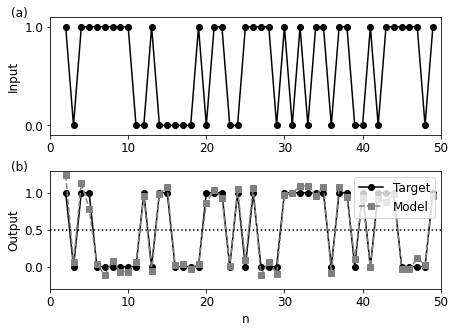

In [6]:
import matplotlib.pyplot as plt

np.random.seed(seed=0)

# 時系列入力データ
T = 50  # 時間長
u = np.random.randint(0, 2, T)  # 2値系列

# 時系列出力データ
tau = 2  
d = np.zeros(T)
for n in range(tau, T):
    d[n] = u[n-1]^u[n-2]  # XOR関数

# 実数に変換
u = u.astype(np.float)
d = d.astype(np.float)

# 学習用情報
train_U = u[tau:T].reshape(-1, 1)
train_D = d[tau:T].reshape(-1, 1)

# ESNモデル
N_x = 20  # リザバーのノード数
model = ESN(train_U.shape[1], train_D.shape[1], N_x, density=0.1, 
            input_scale=1.0, rho=0.9)

# 学習（線形回帰）
model.train(train_U, train_D, Tikhonov(N_x, train_D.shape[1], 0.0))

# モデル出力
train_Y = model.predict(train_U)

# 評価（ビット誤り率, BER）
train_Y_binary = np.zeros(T-tau)
for n in range(T-tau):
    if train_Y[n, 0] > 0.5:
        train_Y_binary[n] = 1
    else:
        train_Y_binary[n] = 0
    
BER = np.linalg.norm(train_Y_binary[0:T-tau]-d[tau:T], 1)/(T-tau)
print('BER =', BER)

# グラフ表示用データ
T_disp = (0, T)
t_axis = np.arange(tau, T)  # 時間軸
disp_U = train_U[T_disp[0]:T_disp[1]]  # 入力
disp_D = train_D[T_disp[0]:T_disp[1], :]  # 目標出力
disp_Y = train_Y[T_disp[0]:T_disp[1], :]  # モデル出力

# グラフ表示
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2, 1, 1)
ax1.text(-0.1, 1, '(a)', transform=ax1.transAxes)
ax1.set_yticks([0.0, 1.0])
plt.plot(t_axis, disp_U[:, 0], color='k', marker='o')
plt.xlim([0, T])
plt.ylim([-0.1, 1.1])
plt.ylabel('Input')
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

ax2 = fig.add_subplot(2, 1, 2)
ax2.text(-0.1, 1, '(b)', transform=ax2.transAxes)
ax2.set_yticks([0, 0.5, 1])
plt.plot(t_axis, disp_D[:, 0], color='k', marker='o', label='Target')
plt.plot(t_axis, disp_Y[:, 0], color='gray', marker='s', 
          linestyle = '--', label='Model')
plt.plot([0, T], [0.5, 0.5], color='k', linestyle = ':')
plt.xlim([0, T])
plt.ylim([-0.3,1.3])
plt.xlabel('n')
plt.ylabel('Output')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right')

plt.show()